In [50]:
import pyprocess as piv
import smoothn
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
from corrLib import readseq
from scipy.signal import medfilt2d

## Tiffstack batch

In [16]:
l = readseq(r'D:\Wei\Dynamics_raw\60')
winsize = 50
searchsize = 100
overlap = 25
dt = 0.033

In [24]:
%%time
for num, i in l.iterrows():
    # read 2 adjacent images
    if num % 2 == 0:
        I0 = io.imread(i.Dir)
        continue 
    I1 = io.imread(i.Dir)
    # run PIV function "extended_search_area_piv()"
    u0, v0 = pyprocess.extended_search_area_piv(I0.astype(np.int32), I1.astype(np.int32), 
                                                         window_size=winsize, overlap=overlap, dt=dt, 
                                                         search_area_size=searchsize)
    x, y = pyprocess.get_coordinates(image_size=I0.shape, window_size=winsize, overlap=overlap) 
    u1 = medfilt2d(u0, kernel_size=3)
    v1 = medfilt2d(v0, kernel_size=3)
    u1[np.isnan(u1)]=0
    v1[np.isnan(v1)]=0
    u2 = medfilt2d(u1, kernel_size=3)
    v2 = medfilt2d(v1, kernel_size=3)
    frame_data = pd.DataFrame(data=np.array([x.flatten(), y.flatten(), u2.flatten(), v2.flatten()]).T,
                   columns=['x', 'y', 'u', 'v']).assign(frame=num)
    if num < 2:
        data = frame_data
    else:
        data = data.append(frame_data)
    if num > 6:
        break

Wall time: 8.87 s


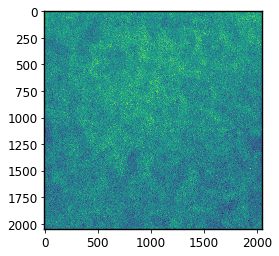

In [29]:
plt.imshow(I0)

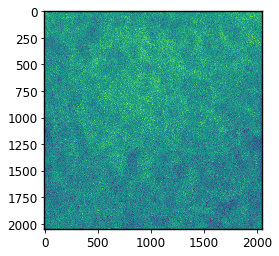

In [30]:
plt.imshow(I1)

## Image sequence batch

In [3]:
# folder = r'I:\Google Drive\Code\Python\PIV\test_images\imseq'
# fileList = readseq(folder)
# frame = 0
# data = pd.DataFrame()
# for num, i in fileList.iterrows():    
#     img = io.imread(i.Dir)
#     if frame % 2 == 0:
#         I0 = img
#         frame += 1
#         continue
#     I1 = img    
#     u0, v0 = process.extended_search_area_piv(I0.astype(np.int32), I1.astype(np.int32), 
#                                                          window_size=winsize, overlap=overlap, dt=dt, 
#                                                          search_area_size=searchsize)
#     x, y = process.get_coordinates(image_size=I0.shape, window_size=winsize, overlap=overlap)
#     u1 = medfilt2d(u0, kernel_size=3)
#     v1 = medfilt2d(v0, kernel_size=3)
#     u1[np.isnan(u1)]=0
#     v1[np.isnan(v1)]=0
#     u2 = medfilt2d(u1, kernel_size=3)
#     v2 = medfilt2d(v1, kernel_size=3)
#     frame_data = pd.DataFrame(data=np.array([x.flatten(), y.flatten(), u2.flatten(), v2.flatten()]).T,
#                    columns=['x', 'y', 'u', 'v']).assign(frame=frame)
#     if num < 2:
#         data = frame_data
#     else:
#         data = data.append(frame_data)
#     frame += 1

## When using sig2noise method, the first velocity field matrices are full of nans. Always use the piv method without using sig2noise parameter, like below.

In [31]:
imgDir = r'I:\Github\Python\PIV\test_images\1.tif'
imgs = io.imread(imgDir)
# load images I0 and I1
for num, img in enumerate(imgs):
    if num == 2:
        break
    # read 2 adjacent images
    if num % 2 == 0:
        I0 = img
        continue    
    I1 = img

In [46]:
winsize = 50 # pixels
searchsize = 50  # pixels, search in image B
overlap = 25 # pixels
dt = 0.1 # sec
# apply piv function
u01, v01 = pyprocess.extended_search_area_piv(I0.astype(np.int32), I1.astype(np.int32), 
                                                         window_size=winsize, overlap=overlap, dt=dt, 
                                                         search_area_size=searchsize)

In [44]:
# get coords
x, y = pyprocess.get_coordinates(image_size=I0.shape, window_size=winsize, overlap=overlap)

(-22.5, 1022.5, -22.5, 1022.5)

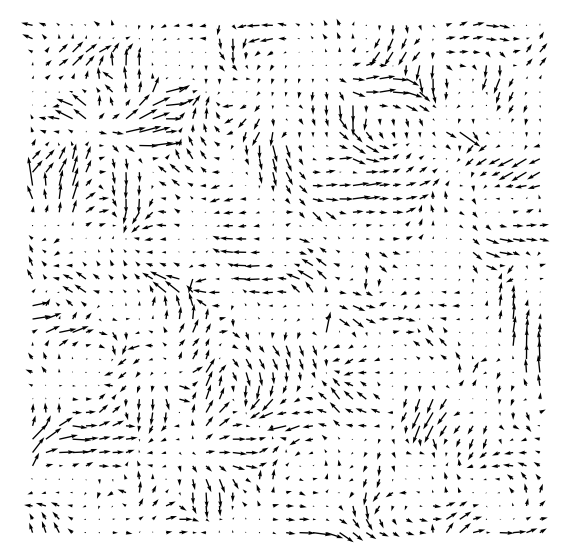

In [59]:
plt.figure(figsize=(10, 10))
us = smoothn.smoothn(u01, smoothOrder=2)
vs = smoothn.smoothn(v01, smoothOrder=2)
plt.quiver(x, y, us[0], vs[0])
plt.axis('off')
plt.axis('equal')

In [57]:
len(vs)

4

In [ ]:
plt.figure(figsize=(10, 6))
plt.quiver(x, y, u01, v01)
plt.axis('off')

## Median filter with kernel_size=3 works well for smoothing the velocity field

In [8]:
# load matpiv data for the first frame pair
# mat = pd.read_csv(r'R:\Dip\DF\PIV_analysis\Analysis_1000\first_dataset.csv')
mat = pd.read_csv(r'E:\Google Drive\Research projects\DF\PIV\Analysis_1000\first_dataset.csv')
mat = mat.loc[mat.frame==1]
mat = mat.loc[(mat.x!=0)&(mat.y!=0)]

In [9]:
umat = np.array(mat.u).reshape(39, 39)
umat2 = medfilt2d(umat)
vmat = np.array(mat.v).reshape(39, 39)
vmat2 = medfilt2d(vmat)

## Comparison with matpiv result show good agreement
* Black: python-openpiv
* Red: matlab-matpiv

(-22.5, 1022.5, -22.5, 1022.5)

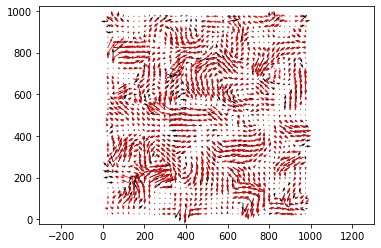

In [10]:
# remove nan values
u01[np.isnan(u01)]=0
v01[np.isnan(v01)]=0
# median filter
u02 = medfilt2d(u01, kernel_size=3)
v02 = medfilt2d(v01, kernel_size=3)
plt.quiver(x, y, u02, v02)
plt.quiver(mat.x, 1000-mat.y, umat2, -vmat2, color='red') 
# 1000-mat.y is because openpiv and matpiv index image differently
plt.axis('equal')

In [11]:
# load openpiv(python) data for the first frame pair
pyt = pd.DataFrame(data=np.array([x.flatten(), y.flatten(), u02.flatten(), v02.flatten()]).T,
                   columns=['x', 'y', 'u', 'v'])
pyt = pyt.reset_index()
# pyt = pyt.sort_values(by=['x', 'y'])

## Quantify this difference
D = sum\[(v1-v2)^2\]/sum\[v1^2\]

In [12]:
mat2 = mat.sort_values(by=['y', 'x'], ascending=[False, True])
# convert to 2d array and apply median filter
umat = np.array(mat2.u).reshape(39, 39)
umat2 = medfilt2d(umat)
vmat = np.array(mat2.v).reshape(39, 39)
vmat2 = medfilt2d(vmat)
# convert back and replace original columns
mat2.u = umat2.flatten()
mat2.v = vmat2.flatten()
# convert mat.y to python coords
mat2.y = 1000 - mat2.y
mat2.v = -mat2.v
mat2 = mat2.sort_values(by=['y', 'x'], ascending=[False, True]).reset_index()

In [13]:
D = ((mat2.u-pyt.u)**2 + (mat2.v-pyt.v)**2) / (pyt.u**2 + pyt.v**2)

In [14]:
Di = ((mat2.u-pyt.u)**2 + (mat2.v-pyt.v)**2).sum() / (pyt.u**2 + pyt.v**2).sum()

In [15]:
D.loc[D<1].mean()

0.33313837085284975

<IPython.core.display.Javascript object>


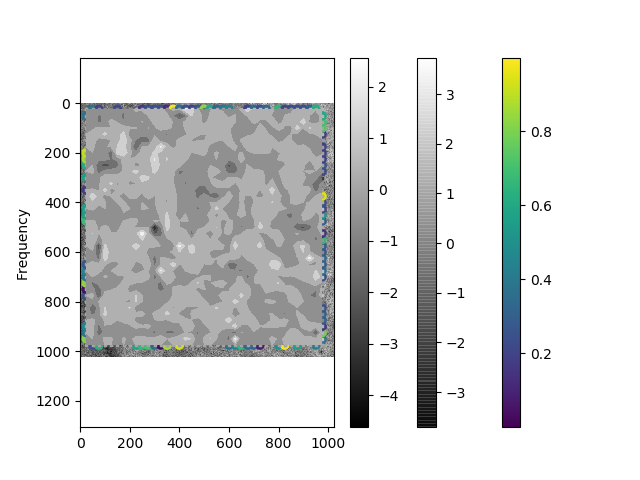

(-22.5, 1022.5, -22.5, 1022.5)

In [16]:
%matplotlib nbagg
plt.quiver(pyt.x, pyt.y, pyt.u, pyt.v)
plt.quiver(mat2.x, mat2.y, mat2.u, mat2.v, color='red') 
plt.axis('equal')

In [17]:
# difference matrix, color indicates difference
plt.scatter(pyt.x.loc[D<1], pyt.y.loc[D<1], c=D.loc[D<1])
plt.colorbar()

In [18]:
# difference histogram
D.loc[D<5].plot.hist()

## Velocity field analysis - divergence and vorticity

In [19]:
# Create vector field x, y, u, v from PIV analysis
u = np.array(pyt.u).reshape(39, 39)
v = np.array(pyt.v).reshape(39, 39)

### div(**v**)(i, j) = (u(i, j) - u(i-1, j))/l + (v(i, j) - v(i, j-1))/l 
### curl(**v**)(i, j) = (v(i, j) - v(i-1, j))/l + (u(i, j) - u(i, j-1))/l
Since both contain i-1, j-1 terms, the matrix of div and curl should be 1 row and 1 col smaller than the original vector field. I will pad the matrix with a row and a col at top and left, filled with zeros, to keep the outcome the same shape as the input.


In [20]:
divmat = np.zeros(x.shape)
l = x[0, 1] - x[0, 0]
for i in range(1, divmat.shape[0]):
    for j in range(1, divmat.shape[1]):
        divmat[i, j] = (u[i, j] - u[i-1, j])/l + (v[i, j] - v[i, j-1])/l

### plot divergence field on top of original image

In [21]:
plt.imshow(I0, cmap='gray')
plt.scatter(x, y, c=divmat, s=2, marker='s', cmap='gray', alpha=0.8)
plt.colorbar()

In [22]:
plt.imshow(I0, cmap='gray')
cs = plt.contourf(x, y, divmat, alpha=1, cmap='gray')

### plot vorticity field on top of original image

In [23]:
curlmat = np.zeros(x.shape)
l = x[0, 1] - x[0, 0]
for i in range(1, divmat.shape[0]):
    for j in range(1, divmat.shape[1]):
        curlmat[i, j] = (v[i, j] - v[i-1, j])/l - (u[i, j] - u[i, j-1])/l

In [24]:
plt.imshow(I0, cmap='gray')
plt.scatter(x, y, c=curlmat, s=2, marker='s', cmap='gray', alpha=1)
plt.colorbar()

In [25]:
plt.imshow(I0, cmap='gray')
cs = plt.contourf(x, y, curlmat, alpha=1, cmap='gray')

## Correlations between intensity and div/curl
* Use intensity field of the first image of each pair

In [26]:
from corrLib import divide_windows

In [33]:
X, Y, I = divide_windows(I0, windowsize=[50, 50], step=25)

In [35]:
I.shape

(39, 39)

In [36]:
divmat.shape

(39, 39)

In [49]:
Inorm = (2*I - I.max() - I.min()) / (I.max() - I.min())

In [56]:
dnorm = (2*divmat - divmat.max() - divmat.min()) / (divmat.max() - divmat.min())

In [57]:
dnorm.max()

1.0

<IPython.core.display.Javascript object>


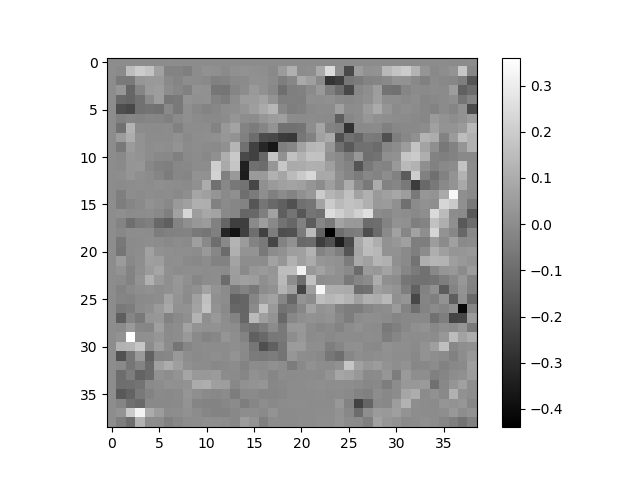

In [60]:
# Compute correlation between the two matrices
plt.imshow(Inorm*dnorm, cmap='gray')
plt.colorbar()

<IPython.core.display.Javascript object>


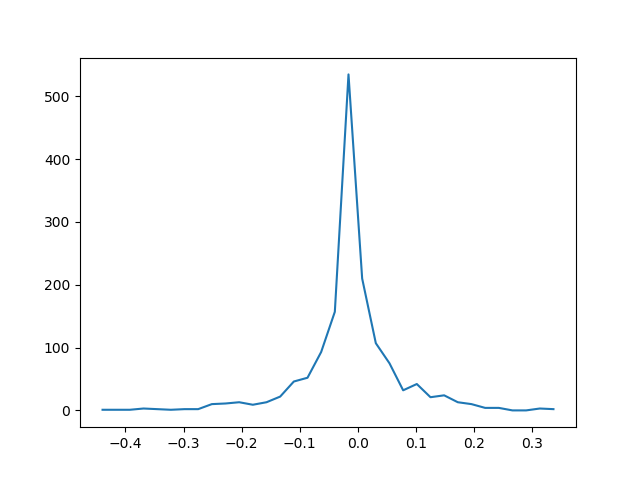

In [63]:
hist, bins = np.histogram(Inorm*dnorm, bins='scott')
plt.plot(bins[:-1], hist)

In [64]:
from pivLib import tiffstackPIV

In [65]:
winsize = 50
searchsize = 100
overlap = 25
dt = 0.1

In [66]:
imgDir = r'E:\Google Drive\Research projects\DF\PIV\1.tif'
data = tiffstackPIV(imgDir, winsize, searchsize, overlap, dt)
data.to_csv(r'E:\Google Drive\Research projects\DF\PIV\pyPIVdata.csv', index=False)

E:\Github\Python\PIV\src\pivLib.py:22: RuntimeWarning: invalid value encountered in double_scalars
  search_area_size=searchsize)


In [74]:
def div(x, y, u, v):
    divmat = np.zeros(x.shape)
    l = x[0, 1] - x[0, 0]
    for i in range(1, divmat.shape[0]):
        for j in range(1, divmat.shape[1]):
            divmat[i, j] = (u[i, j] - u[i-1, j])/l + (v[i, j] - v[i, j-1])/l
    return divmat

In [75]:
def curl(x, y, u, v):
    curlmat = np.zeros(x.shape)
    l = x[0, 1] - x[0, 0]
    for i in range(1, divmat.shape[0]):
        for j in range(1, divmat.shape[1]):
            curlmat[i, j] = (v[i, j] - v[i-1, j])/l - (u[i, j] - u[i, j-1])/l
    return curlmat

In [69]:
imgs = io.imread(imgDir)

In [72]:
x = np.array(data.x.loc[data.frame==1])
x = x.reshape(39, 39)

In [73]:
x

array([[ 25.,  50.,  75., ..., 925., 950., 975.],
       [ 25.,  50.,  75., ..., 925., 950., 975.],
       [ 25.,  50.,  75., ..., 925., 950., 975.],
       ...,
       [ 25.,  50.,  75., ..., 925., 950., 975.],
       [ 25.,  50.,  75., ..., 925., 950., 975.],
       [ 25.,  50.,  75., ..., 925., 950., 975.]])

In [89]:
vf_data = pd.DataFrame()
count = 0
for frame in data.frame.drop_duplicates():
    X, Y, I = divide_windows(I0, windowsize=[50, 50], step=25)
    I0 = imgs[frame-1]
    subdata = data.loc[data.frame==frame]
    x = np.array(subdata.x).reshape(X.shape)
    y = np.array(subdata.y).reshape(X.shape)
    u = np.array(subdata.u).reshape(X.shape)
    v = np.array(subdata.v).reshape(X.shape)
    d = div(x, y, u, v)
    c = curl(x, y, u, v)
    Inorm = (2*I - I.max() - I.min()) / (I.max() - I.min())
    dnorm = (2*d - d.max() - d.min()) / (d.max() - d.min())
    cnorm = (2*c - c.max() - c.min()) / (c.max() - c.min())
    Id = Inorm * dnorm
    Ic = Inorm * cnorm
    subdata = subdata.assign(I=I.flatten(), div=d.flatten(), curl=c.flatten(), Ixdiv=Id.flatten(), Ixcurl=Ic.flatten())
    if count == 0:
        vf_data = subdata
    else:
        vf_data = vf_data.append(subdata)
    count += 1

<IPython.core.display.Javascript object>


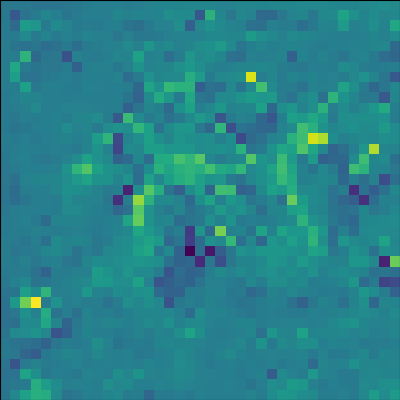

In [103]:
subdata = vf_data.loc[vf_data.frame==1]
x = np.array(subdata.x).reshape(39, 39)
y = np.array(subdata.y).reshape(39, 39)
Id = np.array(subdata.Ixdiv).reshape(39, 39)
Ic = np.array(subdata.Ixcurl).reshape(39, 39)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(Ic)

In [116]:
from IPython.display import clear_output
import os

In [119]:
vf_data

,x,y,u,v,frame,I,div,curl,Ixdiv,Ixcurl
0,25.0,975.0,0.000000,0.000000,1,151.780000,0.000000,0.000000,-0.033776,-0.028666
1,50.0,975.0,0.000000,0.000000,1,152.308000,0.000000,0.000000,-0.032245,-0.027367
2,75.0,975.0,0.000000,23.368911,1,152.397200,0.000000,0.000000,-0.031986,-0.027148
3,100.0,975.0,0.000000,11.554794,1,146.339200,0.000000,0.000000,-0.049549,-0.042053
4,125.0,975.0,0.000000,0.000000,1,145.001200,0.000000,0.000000,-0.053428,-0.045346
5,150.0,975.0,0.000000,0.000000,1,147.706400,0.000000,0.000000,-0.045585,-0.038689
6,175.0,975.0,0.000000,0.000000,1,149.985200,0.000000,0.000000,-0.038979,-0.033082
7,200.0,975.0,0.000000,7.552109,1,153.749600,0.000000,0.000000,-0.028066,-0.023820
8,225.0,975.0,0.000000,10.066147,1,159.023200,0.000000,0.000000,-0.012777,-0.010844
9,250.0,975.0,0.000000,10.066147,1,162.380800,0.000000,0.000000,-0.003043,-0.002583


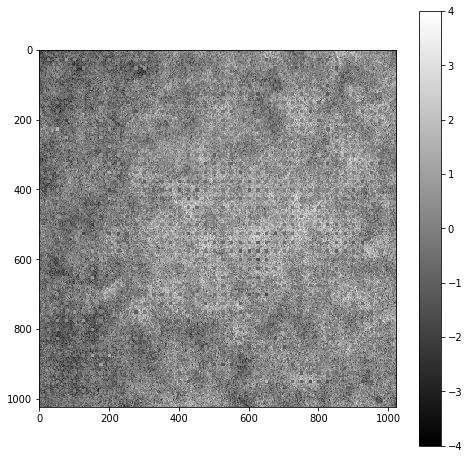

In [128]:
# save div, curl images
folder = r'E:\Github\Python\PIV\test_images\Velocity_field_analysis\curl'
%matplotlib inline
for frame in data.frame.drop_duplicates():
    subdata = vf_data.loc[vf_data.frame==frame]
    x = np.array(subdata.x).reshape(39, 39)
    y = np.array(subdata.y).reshape(39, 39)
    d = np.array(subdata['div']).reshape(39, 39)
    c = np.array(subdata.curl).reshape(39, 39)
    plt.figure(figsize=(8, 8))
    plt.imshow(imgs[frame-1], cmap='gray')
    plt.scatter(x, y, c=c, s=5, marker='s', cmap='gray', vmin=-4, vmax=4)
    plt.colorbar()
    plt.savefig(os.path.join(folder, '{:04d}.png'.format(frame)))
    plt.pause(.1)
    clear_output(wait=True)

In [122]:
subdata.div

<bound method _arith_method_FRAME.<locals>.f of           x      y          u          v  frame           I       div  \
0      25.0  975.0   0.000000   0.000000      1  151.780000  0.000000   
1      50.0  975.0   0.000000   0.000000      1  152.308000  0.000000   
2      75.0  975.0   0.000000  23.368911      1  152.397200  0.000000   
3     100.0  975.0   0.000000  11.554794      1  146.339200  0.000000   
4     125.0  975.0   0.000000   0.000000      1  145.001200  0.000000   
5     150.0  975.0   0.000000   0.000000      1  147.706400  0.000000   
6     175.0  975.0   0.000000   0.000000      1  149.985200  0.000000   
7     200.0  975.0   0.000000   7.552109      1  153.749600  0.000000   
8     225.0  975.0   0.000000  10.066147      1  159.023200  0.000000   
9     250.0  975.0   0.000000  10.066147      1  162.380800  0.000000   
10    275.0  975.0   4.304962  10.066147      1  163.317200  0.000000   
11    300.0  975.0   7.984543   0.000000      1  163.412400  0.000000   
12 

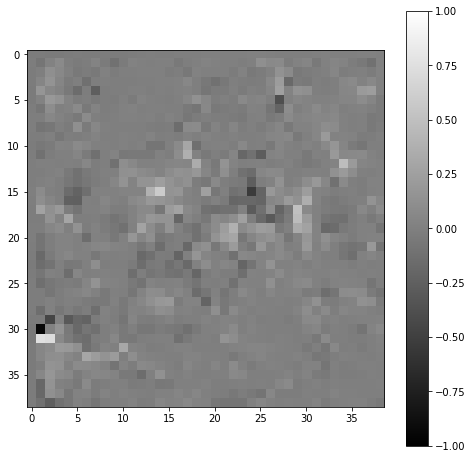

In [118]:
# save Ixdiv, Ixcurl images
folder = r'E:\Github\Python\PIV\test_images\Velocity_field_analysis\Ixcurl'
%matplotlib inline
for frame in data.frame.drop_duplicates():
    subdata = vf_data.loc[vf_data.frame==frame]
    x = np.array(subdata.x).reshape(39, 39)
    y = np.array(subdata.y).reshape(39, 39)
    Id = np.array(subdata.Ixdiv).reshape(39, 39)
    Ic = np.array(subdata.Ixcurl).reshape(39, 39)
    plt.figure(figsize=(8, 8))
    plt.imshow(Ic, cmap='gray', vmin=-1, vmax=1)
    plt.colorbar()
    plt.savefig(os.path.join(folder, '{:04d}.png'.format(frame)))
    plt.pause(.1)
    clear_output(wait=True)

In [2]:
from corrLib import readseq

In [6]:
folder = r'D:\Wei\Dynamics_raw\20'
l = readseq(folder)
l

,Name,Dir
0,0400,D:\Wei\Dynamics_raw\20\0400.tif
1,0401,D:\Wei\Dynamics_raw\20\0401.tif
2,0402,D:\Wei\Dynamics_raw\20\0402.tif
3,0403,D:\Wei\Dynamics_raw\20\0403.tif
4,0404,D:\Wei\Dynamics_raw\20\0404.tif
5,0405,D:\Wei\Dynamics_raw\20\0405.tif
6,0406,D:\Wei\Dynamics_raw\20\0406.tif
7,0407,D:\Wei\Dynamics_raw\20\0407.tif
8,0408,D:\Wei\Dynamics_raw\20\0408.tif
9,0409,D:\Wei\Dynamics_raw\20\0409.tif


,Name,Dir
0,900,D:\Wei\Dynamics_raw\60\900.tif
1,901,D:\Wei\Dynamics_raw\60\901.tif
2,902,D:\Wei\Dynamics_raw\60\902.tif
3,903,D:\Wei\Dynamics_raw\60\903.tif
4,904,D:\Wei\Dynamics_raw\60\904.tif
5,905,D:\Wei\Dynamics_raw\60\905.tif
6,906,D:\Wei\Dynamics_raw\60\906.tif
7,907,D:\Wei\Dynamics_raw\60\907.tif
8,908,D:\Wei\Dynamics_raw\60\908.tif
9,909,D:\Wei\Dynamics_raw\60\909.tif
